# Vizualization

## Import and clean the dataset

In [1]:
import pandas as pd
import numpy as np

PATH = "aggregatedData/first_results.csv"
df = pd.read_csv(PATH, header=0, delimiter=',')
df.rename(columns={'Unnamed: 0':'name', 'Unnamed: 1':'Metric','Unnamed: 2':'Horizontal_axis'},inplace=True)

Create the columns based on the name:

In [2]:
def nameToCol(row):
    features = str(row['name']).split("-")
    for f in features:
        for i,caracter in enumerate(f):
            if caracter.isdigit():
                featureName = f[:i]
                try:
                    row[featureName] = int(f[i:])
                except:
                    row[featureName] = float(f[i:])
                break
    return(row)

df = df.apply(lambda x: nameToCol(x),axis=1)

Concatenate the epochs colums into one list of measurements:

In [3]:
NUMBER_OF_EPOCHS = 200

def epochsToColumn(row):
    listOfMeasures = []
    for c in range(0,NUMBER_OF_EPOCHS):
        listOfMeasures.append(row[str(c)])
    row["measures"] = listOfMeasures  
    return(row)

df = df.apply(lambda x: epochsToColumn(x),axis=1)

Drop unecessary columns:

In [4]:
dropList = ["name"]
for i in range(0,NUMBER_OF_EPOCHS):
    dropList.append(str(i))
    
df = df.drop(columns=dropList)

In [5]:
df.head()

,Metric,Horizontal_axis,nobs,lr,hid,dens,time,measures
0,val_loss,value,16,0.0005,1024,0,1585166311,"[0.05847010388970375, 0.04980831965804099, 0.0..."
1,val_loss,wall_time,16,0.0005,1024,0,1585166311,"[1585166451.1085694, 1585166458.1299765, 15851..."
2,val_D1_loss,value,16,0.0005,1024,0,1585166311,"[0.016223670914769173, 0.015176913700997831, 0..."
3,val_D1_loss,wall_time,16,0.0005,1024,0,1585166311,"[1585166451.1085694, 1585166458.1299765, 15851..."
4,val_D2_loss,value,16,0.0005,1024,0,1585166311,"[0.024494847282767296, 0.018027108162641525, 0..."


Uniques values:

In [6]:
for col in df:
    if str(col)!="time" and str(col)!="measures":
        print(col,"\n",df[col].unique(),"\n")

Metric 
 ['val_loss' 'val_D1_loss' 'val_D2_loss' 'val_D3_loss'
 'val_D1_mean_absolute_error' 'val_D2_mean_absolute_error'
 'val_D3_mean_absolute_error' 'loss' 'D1_loss' 'D2_loss' 'D3_loss'
 'D1_mean_absolute_error' 'D2_mean_absolute_error'
 'D3_mean_absolute_error'] 

Horizontal_axis 
 ['value' 'wall_time'] 

nobs 
 [16 24 36  8] 

lr 
 [0.0005] 

hid 
 [1024  128   32  512] 

dens 
 [   0 1024  128  512] 



## Visualize

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [8]:
mpl.rcParams['figure.figsize'] = (16,9)

Select what we want to see:

In [9]:
dfViz = df[df["Horizontal_axis"] == "value"]
dfViz = dfViz.drop(columns=["Horizontal_axis"])
dfViz = dfViz[dfViz["Metric"] == "loss"]

dfViz.head()

,Metric,nobs,lr,hid,dens,time,measures
14,loss,16,0.0005,1024,0,1585166311,"[0.19761961698532104, 0.052235472947359085, 0...."
42,loss,16,0.0005,1024,1024,1585210705,"[0.088618703186512, 0.04953821375966072, 0.044..."
70,loss,16,0.0005,1024,128,1585167833,"[0.34236130118370056, 0.06694203615188599, 0.0..."
98,loss,16,0.0005,1024,512,1585169395,"[0.4490593671798706, 0.06353069096803665, 0.04..."
126,loss,16,0.0005,128,0,1585162427,"[0.10901565849781036, 0.05186047405004501, 0.0..."


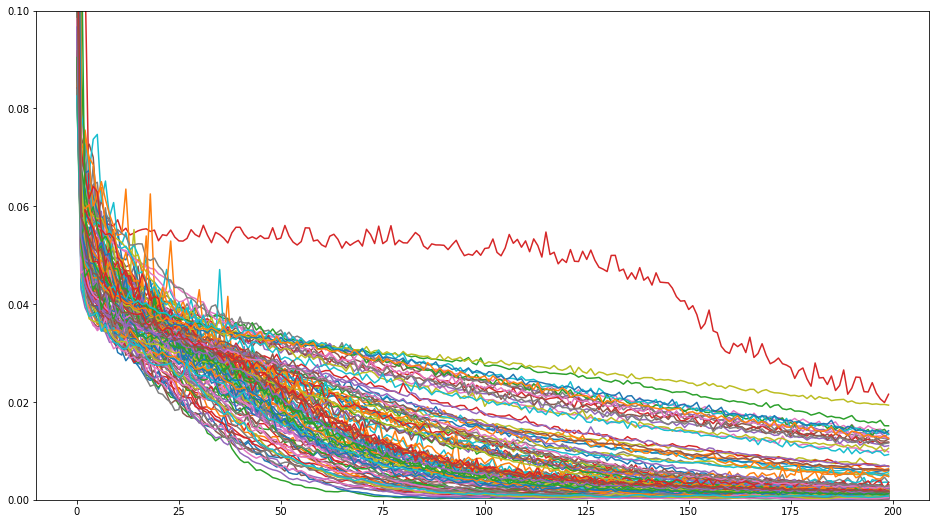

In [10]:
for i, row in dfViz.iterrows():
    plt.plot(row["measures"])
    axes = plt.gca()
    axes.set_xlim()
    axes.set_ylim((0,0.1))
plt.show()